In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, Dropout, Input, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')

tf.config.run_functions_eagerly(True)

videodemo = "/kaggle/input/audio-meta-files/VideoDemographics.csv"
aud = "/kaggle/input/cremad/AudioWAV"
metaf = pd.read_csv(videodemo, usecols=['ActorID', 'Age'])
EPOCHS = 50

In [3]:
def augment_audio(audio, sr=16000, is_young=False):
    noise = np.random.randn(len(audio))
    audio = audio + 0.005 * noise
    pitch_shift = np.random.uniform(-4, 4) if is_young else np.random.uniform(-2, 2)
    audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=pitch_shift)
    audio = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))
    gain_factor = np.random.uniform(0.7, 1.3)
    audio = audio * gain_factor
    return audio

In [4]:
def load_and_preprocess_audio(file_path, target_length=4, sr=16000, n_mfcc=40, hop_length=128, age=None):
    audio, _ = librosa.load(file_path, sr=sr)
    is_young = age is not None and age <= 30
    audio = augment_audio(audio, sr, is_young)
    target_samples = int(target_length * sr)
    if len(audio) < target_samples:
        audio = np.pad(audio, (0, target_samples - len(audio)), mode='constant')
    else:
        audio = audio[:target_samples]
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    pitch, _ = librosa.piptrack(y=audio, sr=sr, hop_length=hop_length)
    pitch = pitch[0, :].reshape(-1, 1)
    features = np.concatenate([mfcc.T, delta.T, delta2.T, pitch], axis=1)
    
    if np.random.random() < 0.5:
        time_mask = np.random.randint(0, 20)
        freq_mask = np.random.randint(0, 5)
        features = np.copy(features)
        for _ in range(2):
            t_start = np.random.randint(0, features.shape[0] - time_mask)
            f_start = np.random.randint(0, features.shape[1] - freq_mask)
            features[t_start:t_start+time_mask, :] = 0
            features[:, f_start:f_start+freq_mask] = 0
    
    features = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-8)
    return features.astype(np.float32)

In [5]:
def create_dataframe():
    a = []
    age = []
    mfcc_paths = []
    output_dir = '/kaggle/working/mfcc_features'
    os.makedirs(output_dir, exist_ok=True)
    
    for file in tqdm(os.listdir(aud)):
        if file.endswith('.wav'):
            temp = file.split('_')
            actor_id = int(temp[0])
            actor_info = metaf[metaf['ActorID'] == actor_id]
            file_path = os.path.join(aud, file)
            
            if not actor_info.empty and os.path.exists(file_path):
                age_value = actor_info['Age'].iloc[0]
                mfcc_features = load_and_preprocess_audio(file_path, age=age_value)
                mfcc_path = os.path.join(output_dir, f'{os.path.splitext(file)[0]}.npy')
                np.save(mfcc_path, mfcc_features)
                a.append(file_path)
                age.append(age_value)
                mfcc_paths.append(mfcc_path)
    
    audio = pd.DataFrame({'Audio': a, 'Age': age, 'MFCC': mfcc_paths})
    age_min, age_max = audio['Age'].min(), audio['Age'].max()
    audio['Age'] = (audio['Age'] - age_min) / (age_max - age_min)
    
    print("Creating AgeBin for stratification")
    bins = np.linspace(audio['Age'].min(), audio['Age'].max(), 10)
    audio['AgeBin'] = pd.cut(audio['Age'], bins, labels=False, include_lowest=True)
    
    audio['AgeYears'] = audio['Age'] * (age_max - age_min) + age_min
    older_ages = audio[audio['AgeYears'] > 60]
    mid_ages = audio[(audio['AgeYears'] >= 40) & (audio['AgeYears'] <= 60)]
    audio = pd.concat([audio, older_ages, older_ages, mid_ages, mid_ages])
    audio = audio.reset_index(drop=True) #Resetting indices after oversampling to avoid duplicates
    
    return audio, age_min, age_max

In [6]:
def create_tf_dataset(df, batch_size=64, train=True, sample_weights=None):
    def load_mfcc(mfcc_path):
        mfcc = np.load(mfcc_path.numpy().decode('utf-8'))
        return mfcc.astype(np.float32)
    
    def parse_data(age, mfcc_path, weight=None):
        mfcc = tf.py_function(
            func=load_mfcc,
            inp=[mfcc_path],
            Tout=tf.float32
        )
        mfcc.set_shape((None, 121))
        age = tf.cast(age, tf.float32)
        if tf.math.is_nan(age):
            tf.print("Found NaN in age for mfcc_path:", mfcc_path)
        
        if train and weight is not None:
            weight = tf.cast(weight, tf.float32)
            return mfcc, age, weight
        return mfcc, age

    if train and sample_weights is not None:
        print(f"Creating training dataset with {len(df)} samples and {len(sample_weights)} weights")
        dataset = tf.data.Dataset.from_tensor_slices(
            (df['Age'].values, df['MFCC'].values, sample_weights)
        )
        dataset = dataset.map(
            lambda age, mfcc_path, weight: parse_data(age, mfcc_path, weight),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    else:
        print(f"Creating dataset with {len(df)} samples (no weights)")
        dataset = tf.data.Dataset.from_tensor_slices(
            (df['Age'].values, df['MFCC'].values)
        )
        dataset = dataset.map(
            lambda age, mfcc_path: parse_data(age, mfcc_path),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    dataset = dataset.cache()
    if train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
def build_model():
    inp = Input((None, 121))
    x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    op = Dense(1, activation='linear', name='Age')(x)
    
    model = Model(inputs=inp, outputs=op)
    model.summary()
    return model

100%|██████████| 7442/7442 [15:19<00:00,  8.10it/s]


Creating AgeBin for stratification
Creating training dataset with 8323 samples and 8323 weights
Creating dataset with 2081 samples (no weights)
Creating dataset with 2602 samples (no weights)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, 121)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, None, 16)       │         5,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, None, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, None, 32)       │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, None, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, None, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, None, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Age (Dense)                     │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,497 (87.88 KB)

 Trainable params: 22,273 (87.00 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.5655 - mae: 0.2636
Epoch 1: val_mae improved from inf to 0.20069, saving model to /kaggle/working/agetask3.weights.h5
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 228ms/step - loss: 0.5639 - mae: 0.2634 - val_loss: 0.0831 - val_mae: 0.2007 - learning_rate: 0.0010
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0569 - mae: 0.1990
Epoch 2: val_mae improved from 0.20069 to 0.19121, saving model to /kaggle/working/agetask3.weights.h5
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - loss: 0.0568 - mae: 0.1990 - val_loss: 0.0179 - val_mae: 0.1912 - learning_rate: 0.0010
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0191 - mae: 0.1859
Epoch 3: val_mae improved from 0.19121 to 0.18596, saving model to /kaggle/working/agetask3.weights.h5
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - loss: 0.0191 - mae: 0.1859 - val_loss: 0.0150 - val_mae: 0.1860 - learning_rate: 0.0010
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1

Text(0.5, 1.0, 'Age Distribution in Dataset')

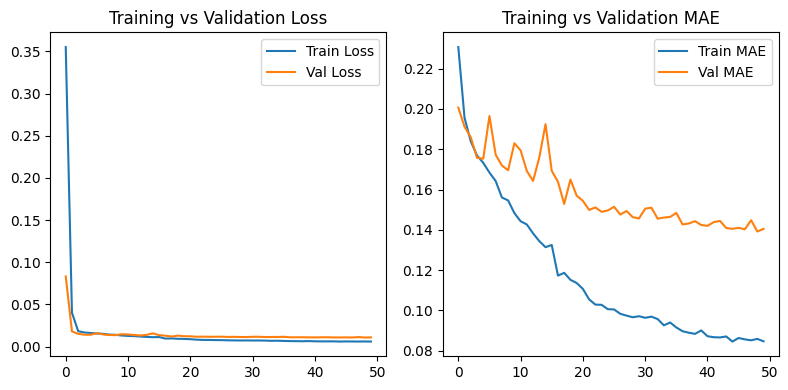

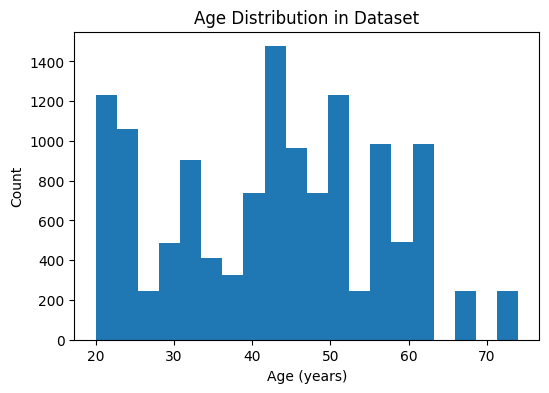

In [ ]:
audio_df, age_min, age_max = create_dataframe()
train_df, test_df = train_test_split(
    audio_df,
    test_size=0.2,
    random_state=42,
    stratify=audio_df['AgeBin']
)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['AgeBin']
)

#Weighted loss for 20-30 bin
weights = audio_df['AgeBin'].map(lambda x: 2.0 if x == 0 else 1.0)
train_ds = create_tf_dataset(train_df, train=True, sample_weights=weights[train_df.index].values)
val_ds = create_tf_dataset(val_df, train=False)
test_ds = create_tf_dataset(test_df, train=False)

model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.Huber(delta=0.1),
    metrics=['mae']
)
checkpoint = ModelCheckpoint(
    '/kaggle/working/agetask3.weights.h5',
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor = 'val_mae',
    patience=10, 
    mode ='min',
    restore_best_weights=True,
)
    
lr_scheduler = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)   
   
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint,early_stopping,lr_scheduler]
)


print("Loading best weights.")
model.load_weights('/kaggle/working/agetask3.weights.h5')

test_results = model.evaluate(test_ds)
mae_in_years = test_results[1] * (age_max - age_min)
print(f"Metrics: {model.metrics_names}")
print(f"Test Results - Total Loss: {test_results[0]:.3f}")
print(f"Age MAE (normalized): {test_results[1]:.3f}")

model.save('/kaggle/working/agetask3.h5')

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()

plt.figure(figsize=(6, 4))
plt.hist(audio_df['Age'] * (age_max - age_min) + age_min, bins=20)
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.title('Age Distribution in Dataset')